# ENSO diversity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
import intake
import cartopy.crs as ccrs
from scipy.interpolate import LSQUnivariateSpline
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import detrend

# choose where to load data from:
load_data_from = 'cloud'
#load_data_from = 'glade'

if load_data_from == 'glade':
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

# models with future scenarios:
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'MIROC-ES2L', 
          'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM', 'MCM-UA-1-0']



/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


## Define functions

In [2]:
def area_weights(lat_bnds, lon_bnds): 
    # computes exact area weigths assuming earth is a perfect sphere
    lowerlats = np.radians(lat_bnds[:,0]); upperlats = np.radians(lat_bnds[:,1])
    difflon = np.radians(np.diff(lon_bnds[0,:])) # if the differences in longitudes are all the same
    areaweights = difflon*(np.sin(upperlats) - np.sin(lowerlats));
    areaweights /= areaweights.mean()
    return areaweights # list of weights, of same dimension as latitude

def numerical_midmonths(xdata):
    # converts xarray monthly time data to numpy array with numerical values
    # for use in functions that cannot use xarray times as input
    midmonths = [int(str(xdata[i])[:4]) + 0.5/12 + int(str(xdata[i])[5:7])/12 for i in range(xdata.shape[0])]
    return np.array(midmonths)


def cub_spl_monthly_detrending3D(xarray, axis=0):
    # detrending by cubic splines, 
    # specifically written for monthly mean ts data ranging from jan 1850 to dec 2100
    xdata = xarray.time.values; ydata = xarray.values # time, lat, lon
    dims = list(np.shape(ydata)); axisdim = dims[axis]; dims.pop(axis)
    times = numerical_midmonths(xdata)
    
    internal_knots = [1850 + (2014-1850)/2, 2014]
    detr_data = np.full((axisdim, dims[0], dims[1]), np.nan)
    for y in range(dims[0]):
        for x in range(dims[1]):
            gridp_data = ydata[:,y,x]
            spl = LSQUnivariateSpline(times, gridp_data, internal_knots)
            detr_data[:,y,x] = gridp_data - spl(times)    
            
    # convert back to xarray:
    detr_xarray = xr.DataArray(detr_data, coords={'time': xarray.time, 'lat': xarray.lat, 'lon': xarray.lon},
                               dims=['time', 'lat', 'lon'])
    detr_xarray = detr_xarray.to_dataset(name = 'detrended_ts')
    return detr_xarray

def sel_member(model): # finds members chosen for historical and ssp experiments
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0', 'CESM2', 'CESM2-WACCM']:
        chosen_member = 'r1i1p1f1'
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1','MCM-UA-1-0', 'UKESM1-0-LL']:
        chosen_member = 'r1i1p1f2'
    elif model in ['CNRM-ESM2-1']:
        chosen_member = 'r2i1p1f2'
    return chosen_member

def picontrol_member(model): # finds members chosen for piControl
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0', 'MCM-UA-1-0', 'CESM2', 'CESM2-WACCM']:
        chosen_member = 'r1i1p1f1'
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1', 'UKESM1-0-LL', 'CNRM-ESM2-1']:
        chosen_member = 'r1i1p1f2'
    return chosen_member

## load surface temperatures

In [52]:
# choose a model:

model = models[8];
print(model)

CESM2


In [53]:
exp_list = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
exp_keys = {}; datasets = {}
for exp in exp_list:
    print(exp)
    if exp == 'piControl':
        member = picontrol_member(model)
    else:
        member = sel_member(model)
    cat = col.search(experiment_id = exp, source_id = model, variable_id='ts', table_id='Amon', member_id = member)
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
    for key in dset_dict.keys():
        exp_keys[exp] = key
        datasets[key] = dset_dict[key]

piControl
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
historical
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp126
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp245
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp370
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp585
--> The keys in the returned di

In [54]:
latregion = slice(-15,15); lonregion = slice(140, 280) # = 140 E - 80 W
# use larger region before regridding, that adds 5 deg to each border:
larger_latregion = slice(-20,20); larger_lonregion = slice(135, 285)
#larger_latregion = slice(-25,25); larger_lonregion = slice(130, 290)

resolution = 1;
ds_out = xr.Dataset({'lon': (['lon'], np.arange(lonregion.start+resolution/2, lonregion.stop+resolution/2, resolution)),
                     'lat': (['lat'], np.arange(latregion.start+resolution/2, latregion.stop+resolution/2, resolution))
                    }
                   )
    
regr_lat_bnds = np.array([[upper, upper+resolution] for upper in range(latregion.start,latregion.stop)])
regr_lon_bnds = np.array([[upper, upper+resolution] for upper in range(lonregion.start,lonregion.stop)])
area_w = area_weights(regr_lat_bnds, regr_lon_bnds)

if model == 'MCM-UA-1-0': 
    exp_list = ['piControl', 'ssp245', 'ssp370', 'ssp585']
else:
    exp_list = ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

anomalies = {}
for exp in exp_list:
    if exp in exp_keys:
        print(exp)
        
        key = exp_keys[exp]
        if exp == 'piControl':
            member = picontrol_member(model)
            ds = datasets[key].sel(member_id = member)
            if model == 'MCM-UA-1-0':
                ds = ds.rename({'longitude': 'lon','latitude': 'lat'})
            
            
            regional_data = ds.ts.sel(lat = larger_latregion, lon = larger_lonregion)
            regridder = xe.Regridder(regional_data, ds_out, 'bilinear', reuse_weights = True)
            regridded_data = regridder(regional_data)
            
            # linear detrending for first 500 years:
            ds_detr = xr.apply_ufunc(detrend, regridded_data[:500*12], kwargs={'axis': -1}, dask = 'allowed')
        else:
            member = sel_member(model)
            hist_ds = datasets[exp_keys['historical']].sel(member_id = member)
            ds = datasets[key].sel(member_id = member)
            # concatenate and make sure dataset stops in year 2100:
            ds = xr.concat([hist_ds, ds], dim = 'time').isel(time=slice(0,3012))
            # concatenate historical and ssp, where the historical part is only
            # used to get a better trend estimate in ssp period
            if model == 'MCM-UA-1-0':
                ds = ds.rename({'longitude': 'lon','latitude': 'lat'})
            regional_data = ds.ts.sel(lat = larger_latregion, lon = larger_lonregion)
            regridder = xe.Regridder(regional_data, ds_out, 'bilinear', reuse_weights = True)
            regridded_data = regridder(regional_data) 
            # apply cubic spline detrending at every point:
            ds_detr = cub_spl_monthly_detrending3D(regridded_data, axis=0)
            # use only ssp time period from now on:
            ds_detr = ds_detr.isel(time=slice(1980,3012))
        
        # deseasonalise
        ts_clim = ds_detr.groupby('time.month').mean(dim='time')
        ts_anom = ds_detr.groupby('time.month') - ts_clim
        anomalies[exp] = ts_anom
        

piControl
Reuse existing file: bilinear_42x121_30x140.nc
ssp126
Reuse existing file: bilinear_42x121_30x140.nc
ssp245
Reuse existing file: bilinear_42x121_30x140.nc
ssp370
Reuse existing file: bilinear_42x121_30x140.nc
ssp585
Reuse existing file: bilinear_42x121_30x140.nc


In [55]:
# do EOF analysis for piControl
data = anomalies['piControl'].transpose('time', 'lon', 'lat')
solver = Eof(data, weights=np.sqrt(area_w))

eofs = solver.eofs(neofs=2)#AsCorrelation(neofs=2)
pcs = solver.pcs(npcs=2)
variance_fractions = solver.varianceFraction(neigs=2)


In [56]:
variance_fractions

<xarray.DataArray 'variance_fractions' (mode: 2)>
array([0.34780287, 0.09307572])
Coordinates:
  * mode     (mode) int64 0 1
Attributes:
    long_name:  variance_fractions

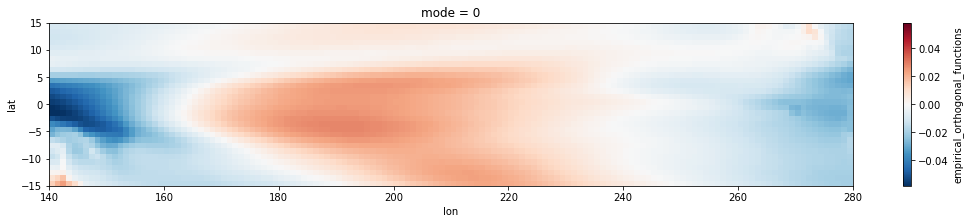

In [57]:
eofs.sel(mode=0).transpose().plot(aspect = 6, size = 3)

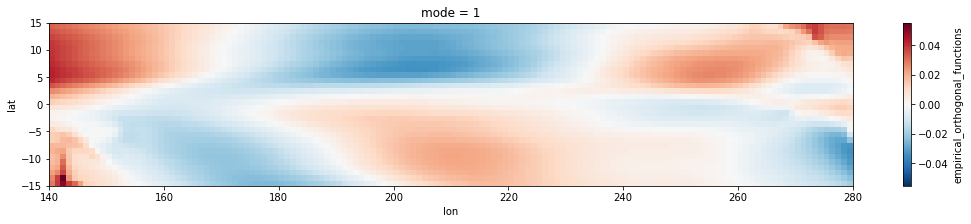

In [58]:
eofs.sel(mode=1).transpose().plot(aspect = 6, size = 3)

In [155]:
proj_data = anomalies['ssp585'].detrended_ts.transpose('time', 'lon', 'lat')
pseudo_pcs = solver.projectField(proj_data, neofs=2)


## Loop over models:

In [5]:
 # use larger region before regridding, that adds 5 deg to each border:
latregion = slice(-15,15); lonregion = slice(140, 280) # = 140 E - 80 W
larger_latregion = slice(-20,20); larger_lonregion = slice(135, 285)
resolution = 1;
ds_out = xr.Dataset({'lon': (['lon'], np.arange(lonregion.start+resolution/2, lonregion.stop+resolution/2, resolution)),
                     'lat': (['lat'], np.arange(latregion.start+resolution/2, latregion.stop+resolution/2, resolution))
                    }
                   )
regr_lat_bnds = np.array([[upper, upper+resolution] for upper in range(latregion.start,latregion.stop)])
regr_lon_bnds = np.array([[upper, upper+resolution] for upper in range(lonregion.start,lonregion.stop)])
area_w = area_weights(regr_lat_bnds, regr_lon_bnds)

# choose a model:
for model in models:
    
    #### load data ####
    exp_list = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
    exp_keys = {}; datasets = {}
    for exp in exp_list:
        print(exp)
        if exp == 'piControl':
            member = picontrol_member(model)
        else:
            member = sel_member(model)
        cat = col.search(experiment_id = exp, source_id = model, variable_id='ts', table_id='Amon', member_id = member)
        dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
        for key in dset_dict.keys():
            exp_keys[exp] = key
            datasets[key] = dset_dict[key]
    
    if model == 'MCM-UA-1-0': 
        exp_list = ['piControl', 'ssp245', 'ssp370', 'ssp585']
    else:
        exp_list = ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

    #### detrend data ####
    anomalies = {}
    for exp in exp_list:
        if exp in exp_keys:
            print(model, exp)

            key = exp_keys[exp]
            if exp == 'piControl':
                member = picontrol_member(model)
                ds = datasets[key].sel(member_id = member)
                if model == 'MCM-UA-1-0':
                    ds = ds.rename({'longitude': 'lon','latitude': 'lat'})

                regional_data = ds.ts.sel(lat = larger_latregion, lon = larger_lonregion)
                regridder = xe.Regridder(regional_data, ds_out, 'bilinear', reuse_weights = True)
                regridded_data = regridder(regional_data)

                # linear detrending for first 500 years:
                ds_detr = xr.apply_ufunc(detrend, regridded_data[:500*12], kwargs={'axis': -1}, dask = 'allowed')
            else:
                member = sel_member(model)
                hist_ds = datasets[exp_keys['historical']].sel(member_id = member)
                ds = datasets[key].sel(member_id = member)
                # concatenate and make sure dataset stops in year 2100:
                ds = xr.concat([hist_ds, ds], dim = 'time').isel(time=slice(0,3012))
                # concatenate historical and ssp, where the historical part is only
                # used to get a better trend estimate in ssp period
                if model == 'MCM-UA-1-0':
                    ds = ds.rename({'longitude': 'lon','latitude': 'lat'})
                regional_data = ds.ts.sel(lat = larger_latregion, lon = larger_lonregion)
                regridder = xe.Regridder(regional_data, ds_out, 'bilinear', reuse_weights = True)
                regridded_data = regridder(regional_data) 
                # apply cubic spline detrending at every point:
                ds_detr = cub_spl_monthly_detrending3D(regridded_data, axis=0)
                # use only ssp time period from now on:
                ds_detr = ds_detr.isel(time=slice(1980,3012))

            # deseasonalise
            ts_clim = ds_detr.groupby('time.month').mean(dim='time')
            ts_anom = ds_detr.groupby('time.month') - ts_clim
            anomalies[exp] = ts_anom
            
    #### do EOF analysis ####    
    # for piControl
    data = anomalies['piControl'].transpose('time', 'lon', 'lat')
    solver = Eof(data, weights=np.sqrt(area_w))
    eofs = solver.eofs(neofs=2)
    pcs = solver.pcs(npcs=2)
    variance_fractions = solver.varianceFraction(neigs=2)
    
    # project fields from other experiments onto piControl EOFs
    for exp in exp_list[1:]:
        proj_data = anomalies[exp].detrended_ts.transpose('time', 'lon', 'lat')
        pseudo_pcs = solver.projectField(proj_data, neofs=2)
        pseudo_pcs = pseudo_pcs.to_dataset(name = model + '_' + exp + '_pseudo_pcs')
        if model == models[0] and exp == exp_list[1]:
            all_pseudo_pcs = pseudo_pcs
            ssp_time_coord = pseudo_pcs.time
        else:
            pseudo_pcs = pseudo_pcs.assign_coords(time = ssp_time_coord)
            all_pseudo_pcs = xr.merge([all_pseudo_pcs, pseudo_pcs])
    
    # include model name in variable name, and merge xarrays
    variance_fractions = variance_fractions.to_dataset(name = model + '_variance_fractions')
    eofs = eofs.to_dataset(name = model + '_eofs')
    pcs = pcs.to_dataset(name = model + '_pcs')
    
    if model in models[1:]: # then xarray already exists that we can merge with
        all_variance_fractions = xr.merge([all_variance_fractions, variance_fractions])
        all_eofs = xr.merge([all_eofs, eofs])
        # convert time axes of all pcs to the same values as the first model
        # In that way the final dataset takes up less space
        pcs = pcs.assign_coords(time = fixed_time_coord[:len(pcs.time)])
        all_pcs = xr.merge([all_pcs, pcs])
    else: # create xarrays
        all_variance_fractions = variance_fractions
        all_eofs = eofs; all_pcs = pcs;
        fixed_time_coord = pcs.time
        


piControl
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
historical
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp126
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp245
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp370
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp585
--> The keys in the returned di

In [3]:
# save files to netcdf:

#all_eofs.to_netcdf('../Processed_data/eof_data/piControl_2eofs.nc')
#all_pcs.to_netcdf('../Processed_data/eof_data/piControl_2pcs.nc')
#all_variance_fractions.to_netcdf('../Processed_data/eof_data/piControl_2variance_fractions.nc')
#all_pseudo_pcs.to_netcdf('../Processed_data/eof_data/ssp_pseudo_pcs.nc')

# load previously saved netcdf files
all_eofs = xr.open_dataset('../Processed_data/eof_data/piControl_2eofs.nc')
all_pcs = xr.open_dataset('../Processed_data/eof_data/piControl_2pcs.nc')
all_variance_fractions = xr.open_dataset('../Processed_data/eof_data/piControl_2variance_fractions.nc')
all_pseudo_pcs = xr.open_dataset('../Processed_data/eof_data/ssp_pseudo_pcs.nc')



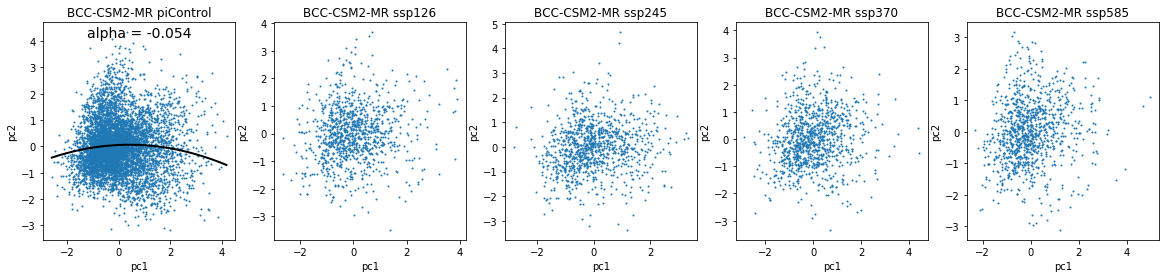

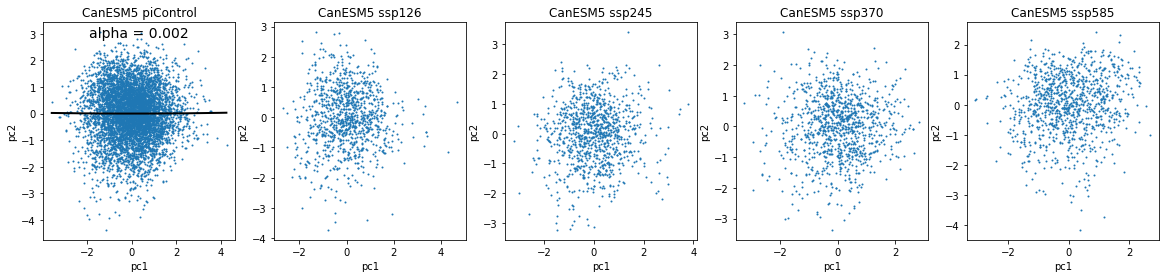

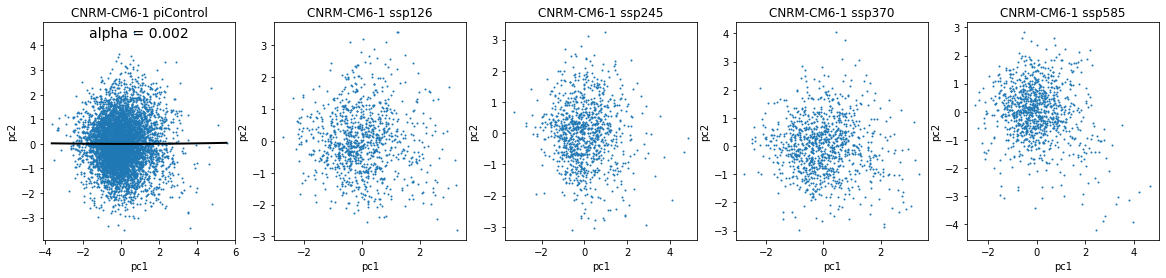

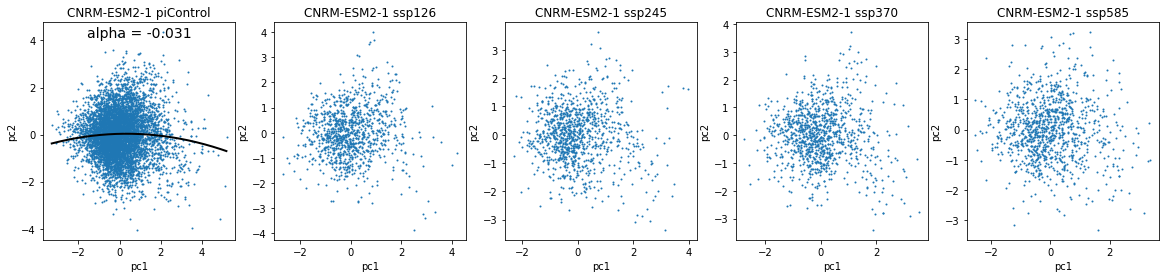

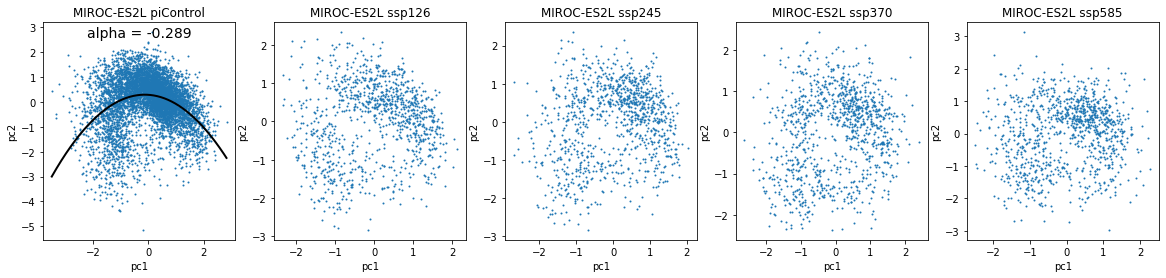

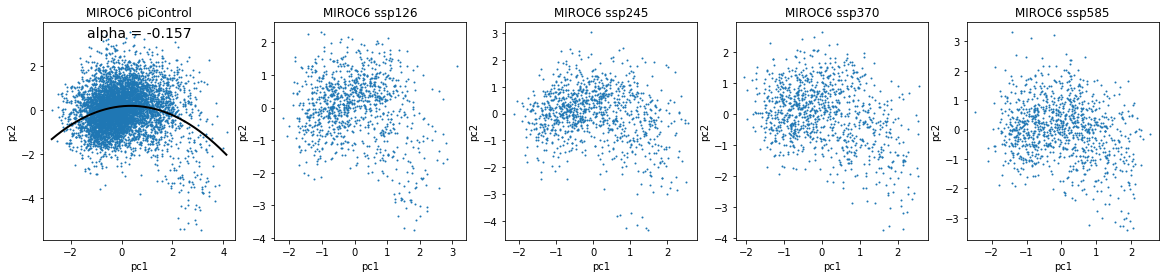

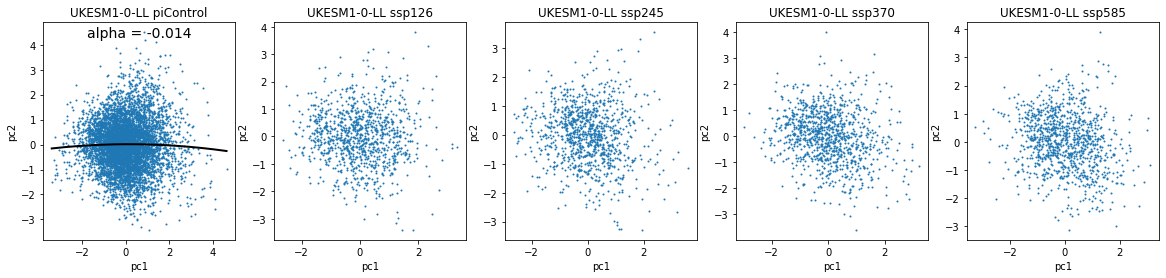

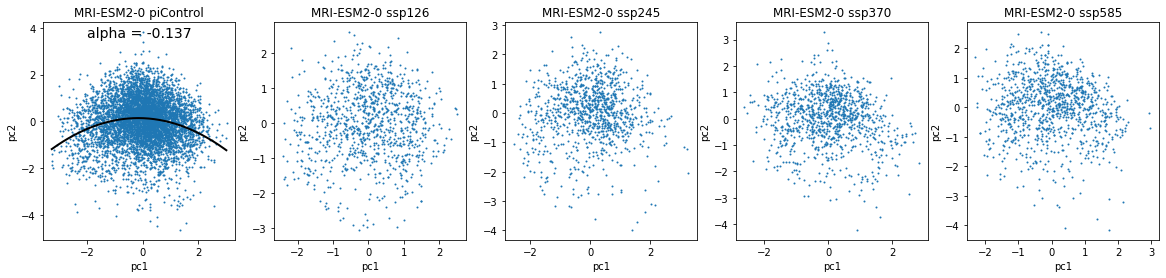

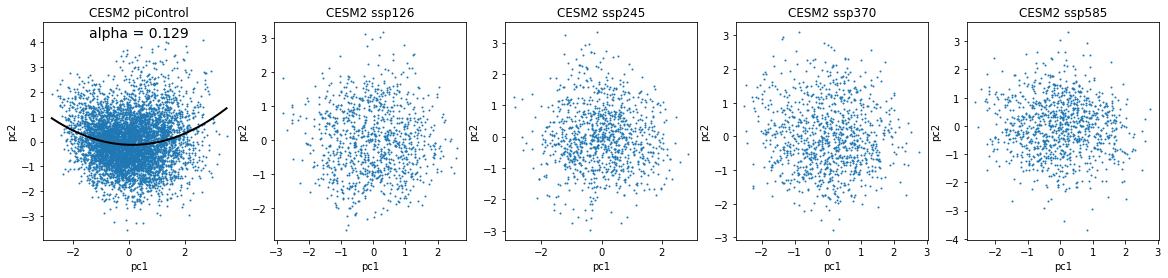

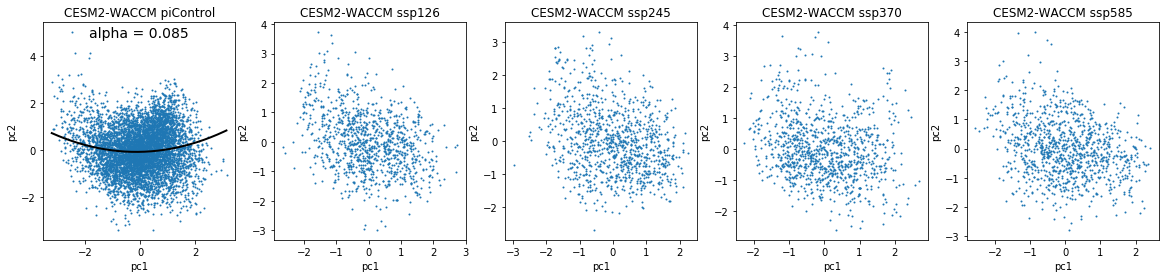

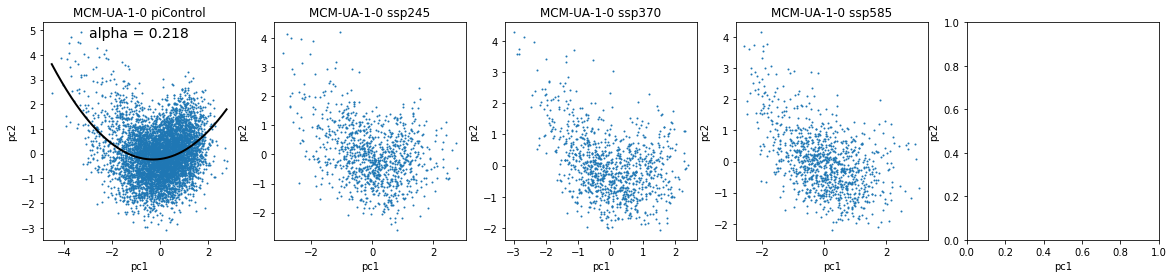

In [5]:
for model in models:
    var = model + '_pcs'
    pc1 = all_pcs[var].sel(mode=0)
    pc2 = all_pcs[var].sel(mode=1)
    fig, ax = plt.subplots(ncols = 5, figsize = [20,4])
    ax[0].scatter(pc1/pc1.std(), pc2/pc2.std(), s = 1)
    ax[0].set_title(model + ' piControl')
    
    # quadratic fit
    x = pc1.dropna(dim='time').values; y = pc2.dropna(dim='time').values
    x = x/np.std(x); y = y/np.std(y); x2= np.arange(min(x),max(x),0.01)
    p2 = np.polyfit(x, y, 2)
    #print('alpha = ', p2[0])
    qfit = np.polyval(p2, x2)
    ax[0].plot(x2, qfit, color = "black", linewidth = 2)
    ax[0].text(0.5, 0.95, 'alpha = ' + str(np.round(p2[0],3)), fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes);
    
    if model == 'MCM-UA-1-0': 
        exp_list = ['ssp245', 'ssp370', 'ssp585']
    else:
        exp_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
    
    for (i,exp) in enumerate(exp_list):
        var = model + '_' + exp + '_pseudo_pcs'
        pc1 = all_pseudo_pcs[var].sel(mode=0)
        pc2 = all_pseudo_pcs[var].sel(mode=1)
        ax[i+1].scatter(pc1/pc1.std(), pc2/pc2.std(), s = 1)
        ax[i+1].set_title(model + ' ' + exp)
    
    for axis in ax:
        axis.set_xlabel('pc1')
        axis.set_ylabel('pc2')
        


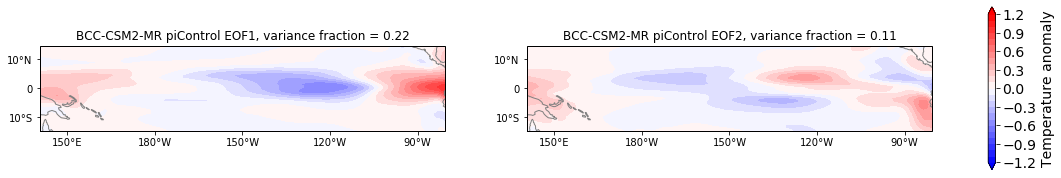

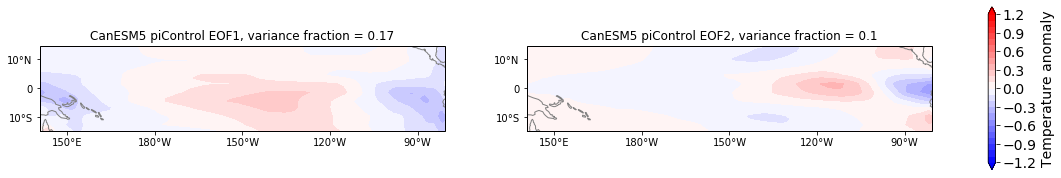

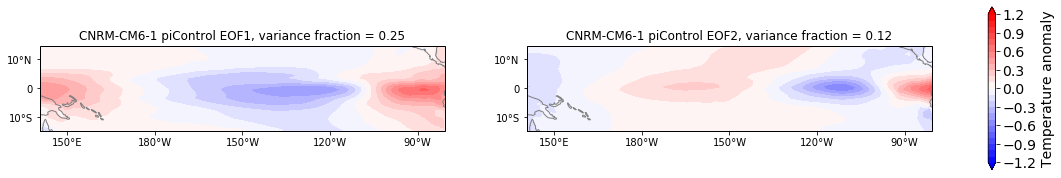

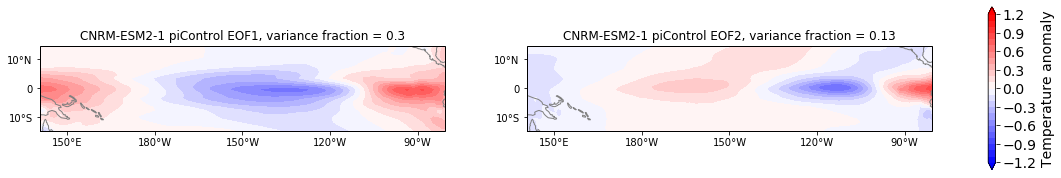

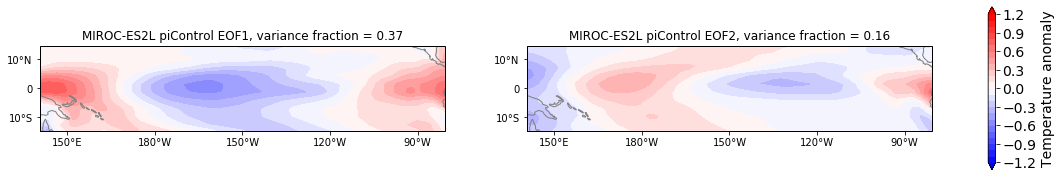

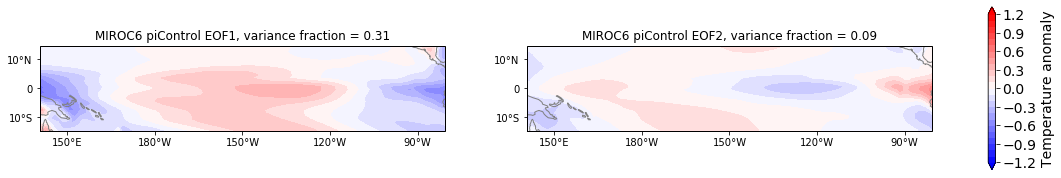

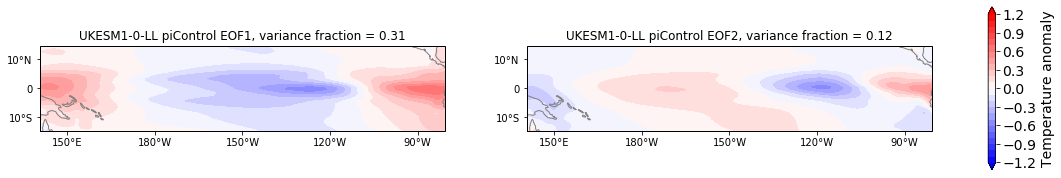

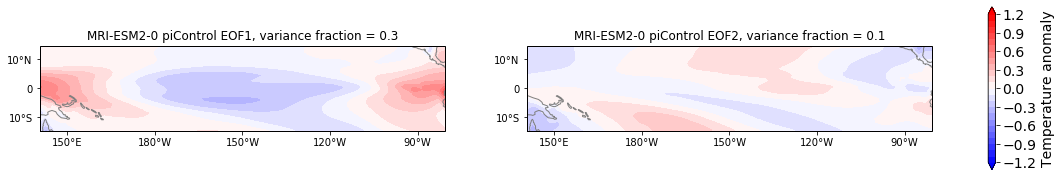

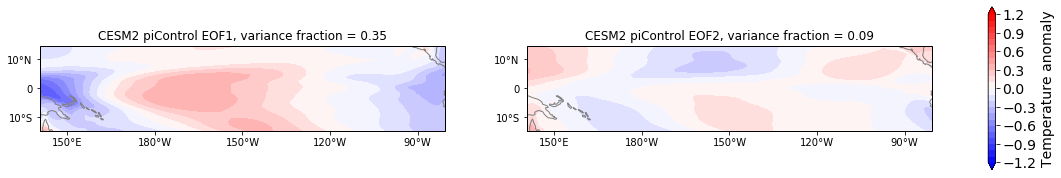

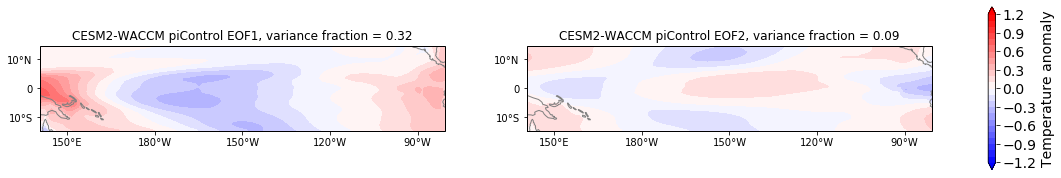

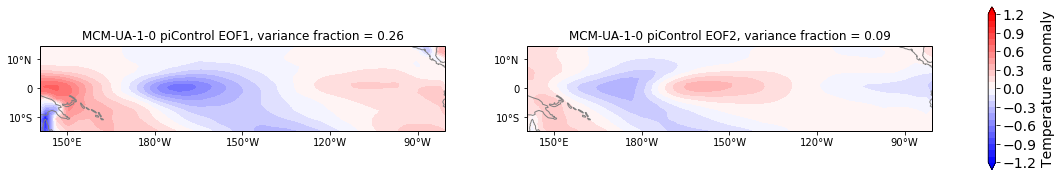

In [6]:

maxval = 1.2; step = 0.1
data_crs = ccrs.PlateCarree(central_longitude=180.0)

for model in models:
    var = model + '_eofs'; var_frac = model + '_variance_fractions'
    eof1 = all_eofs[var].sel(mode=0); var_frac1 = all_variance_fractions[var_frac].sel(mode=0).values
    eof2 = all_eofs[var].sel(mode=1); var_frac2 = all_variance_fractions[var_frac].sel(mode=1).values
    
    var2 = model + '_pcs'
    pc1 = all_pcs[var2].sel(mode=0)
    pc2 = all_pcs[var2].sel(mode=1)
    fig, ax = plt.subplots(ncols = 2, figsize = [20,3], subplot_kw={'projection': data_crs})
    
    #(eof1*pc1.std()).transpose().plot(ax = ax[0])
    #(eof2*pc2.std()).transpose().plot(ax = ax[1])
    
    cs0 = ax[0].contourf(all_eofs.lon, all_eofs.lat, (eof1*pc1.std()).transpose(), np.arange(-maxval,maxval+step,step), cmap = 'bwr',extend='both', transform=ccrs.PlateCarree())
    cs1 = ax[1].contourf(all_eofs.lon, all_eofs.lat, (eof2*pc2.std()).transpose(), np.arange(-maxval,maxval+step,step), cmap = 'bwr',extend='both', transform=ccrs.PlateCarree())
    for i in [0,1]:
        #ax[i].set_global()
        ax[i].coastlines(color='gray')
    cbar = fig.colorbar(cs1, ax = ax.ravel().tolist(), orientation="vertical")
    cbar.set_label('Temperature anomaly', fontsize = 14)
    cbar.ax.tick_params(labelsize = 14)
    
    ax[0].set_title(model + ' piControl EOF1, variance fraction = ' + str(np.round(var_frac1,2)))
    ax[1].set_title(model + ' piControl EOF2, variance fraction = ' + str(np.round(var_frac2,2)))
    
    plt.setp(ax, xticks = np.arange(150, 280, 30)-180, xticklabels = ['150°E', '180°W', '150°W', '120°W', '90°W'])
    plt.setp(ax, yticks = [-10, 0, 10], yticklabels = ['10°S', '0', '10°N'])
    

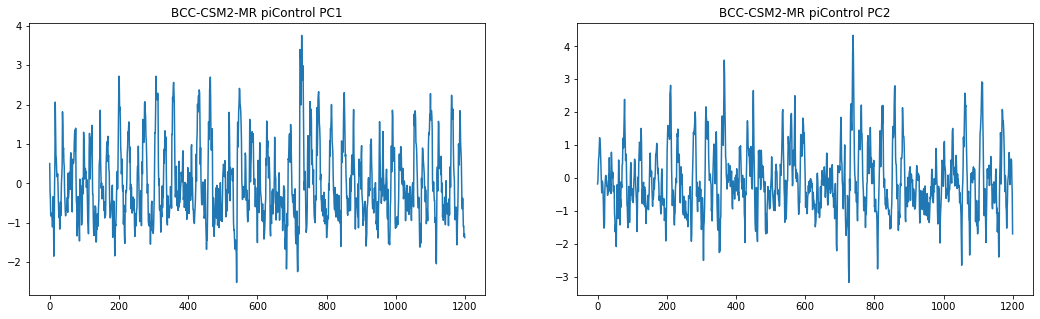

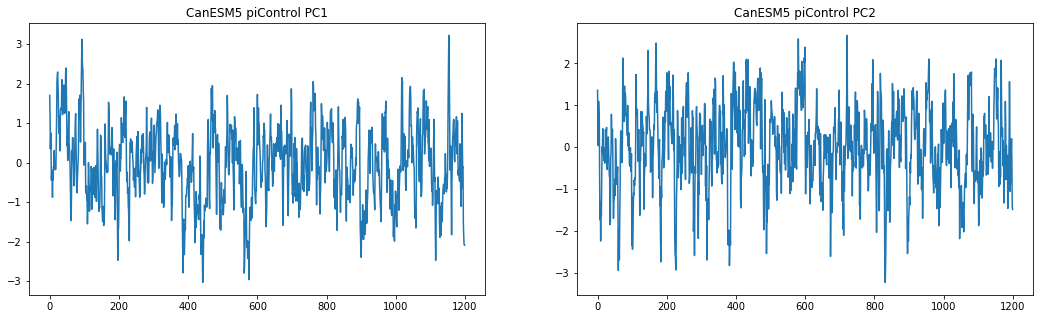

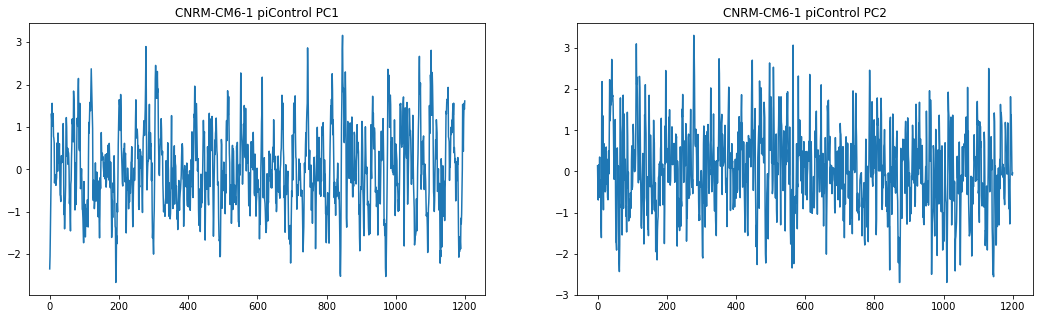

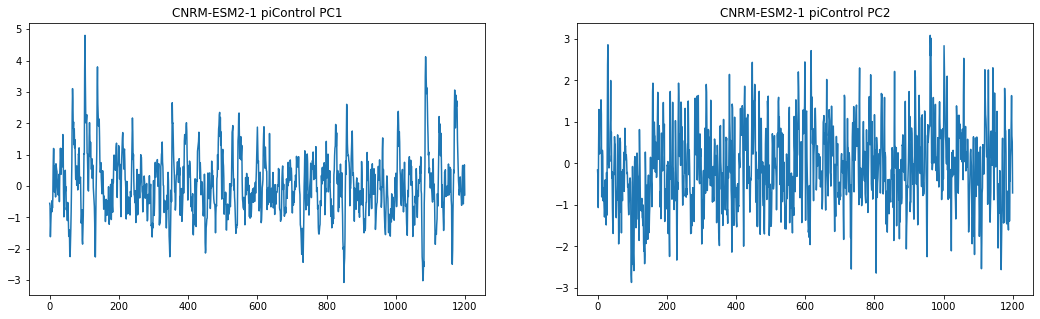

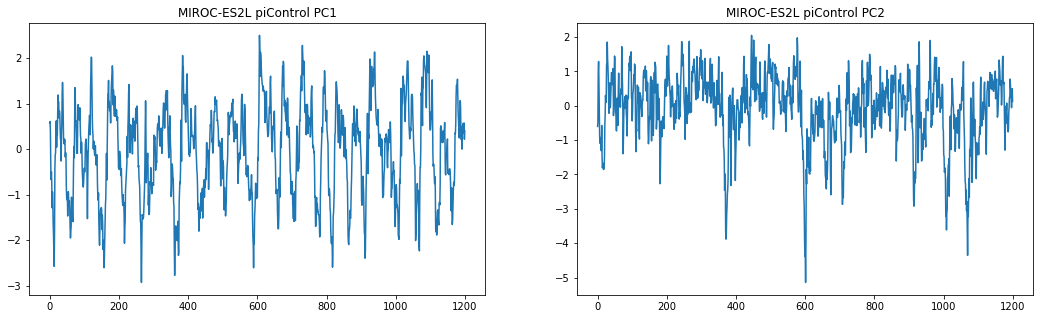

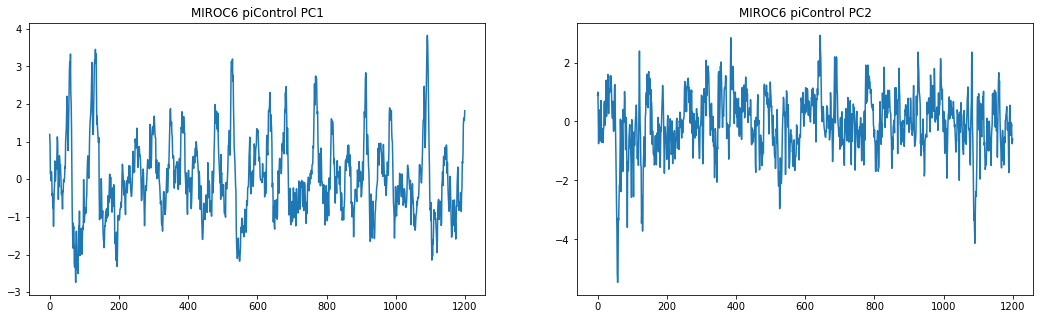

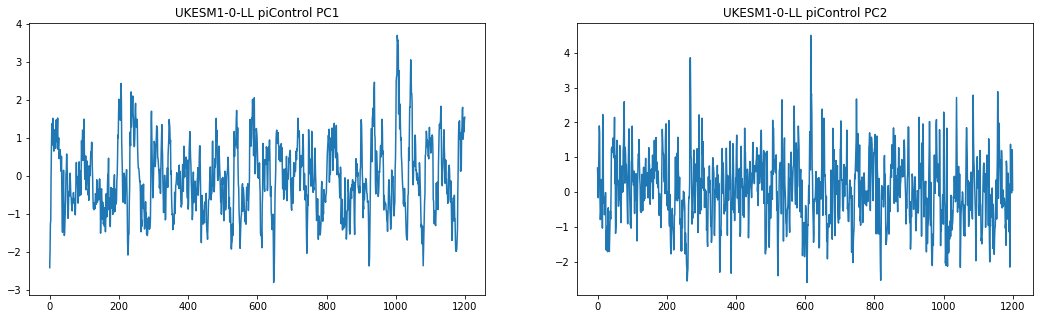

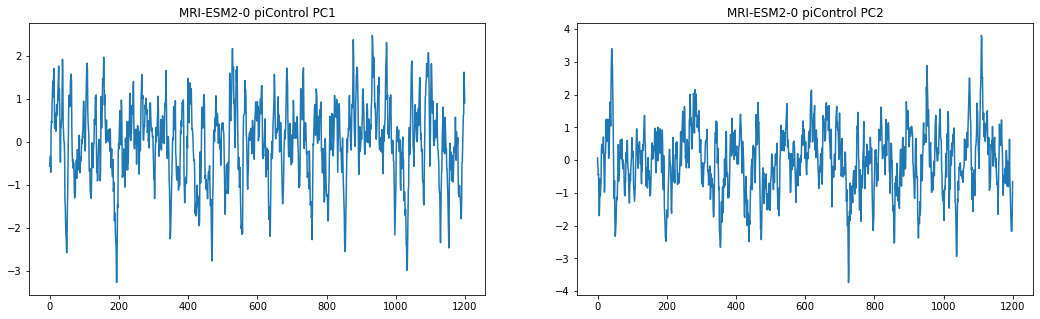

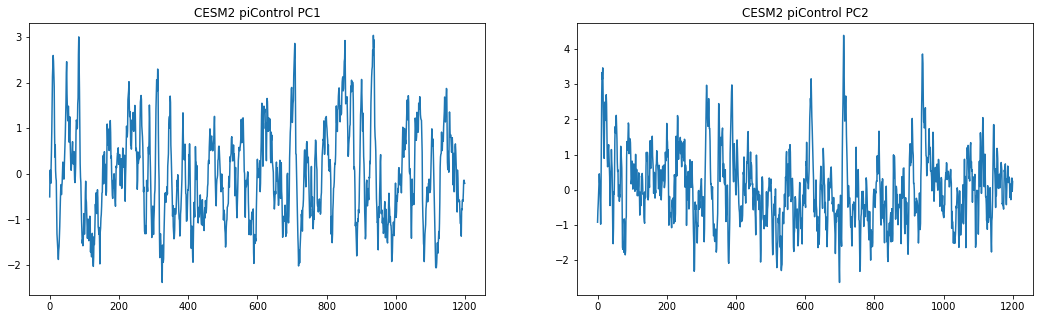

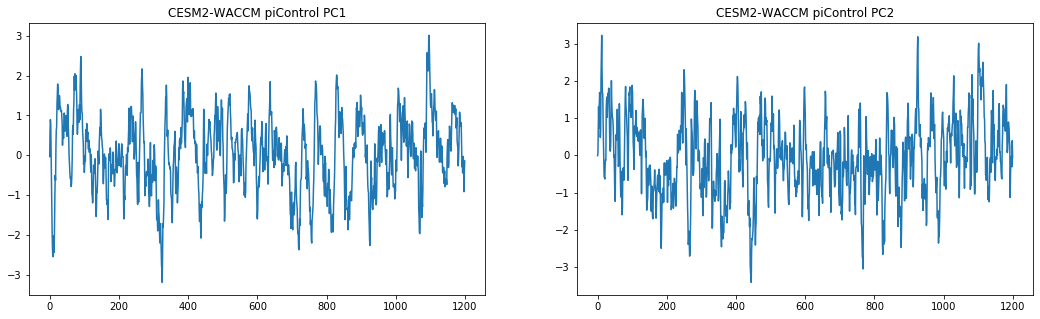

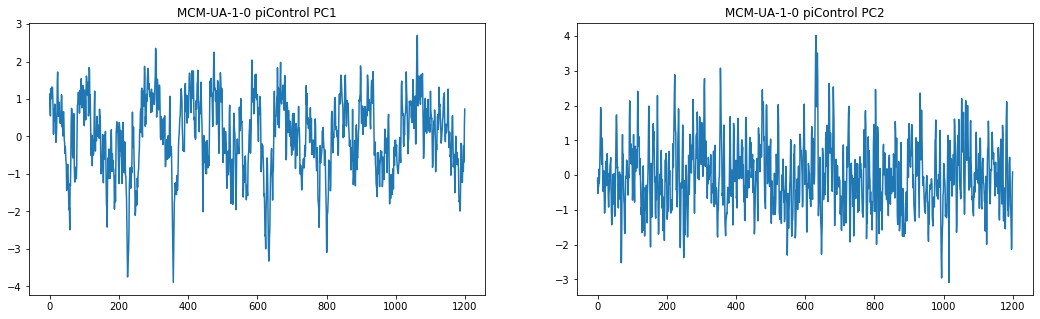

In [8]:
for model in models:
    var = model + '_pcs'
    pc1 = all_pcs[var].sel(mode=0)
    pc2 = all_pcs[var].sel(mode=1)
    fig, ax = plt.subplots(ncols = 2, figsize = [18,5])
    
    ax[0].plot(pc1[:100*12]/pc1.std())
    ax[1].plot(pc2[:100*12]/pc2.std())
    
    ax[0].set_title(model + ' piControl PC1')
    ax[1].set_title(model + ' piControl PC2')
        
    

## Patterns associated with C-index and E-index

I have defined them such that:

EOF1 * PC1 + EOF2 * PC2   

=  

C-index * CP-ENSO pattern + E-index * EP-ENSO pattern

I am not sure if this is what Cai et al did too?

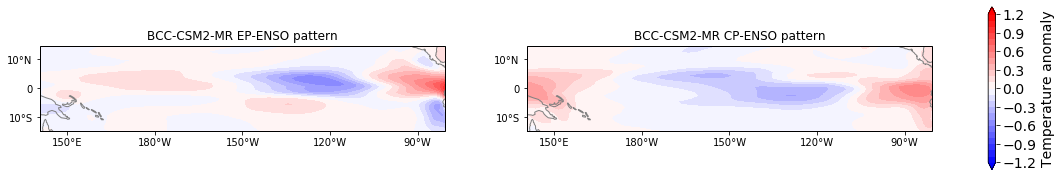

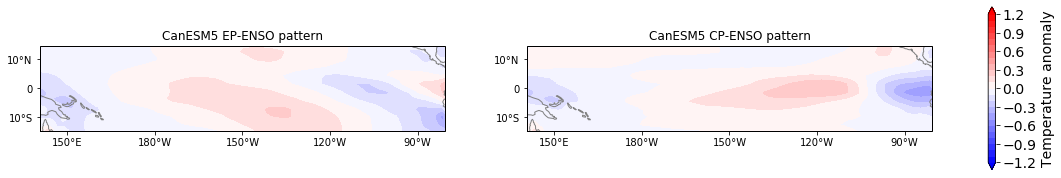

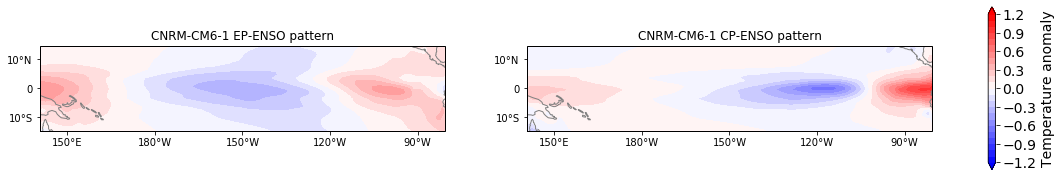

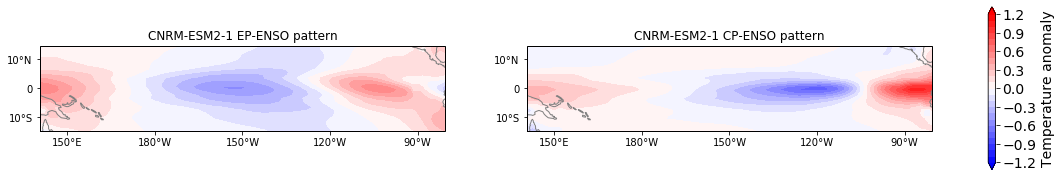

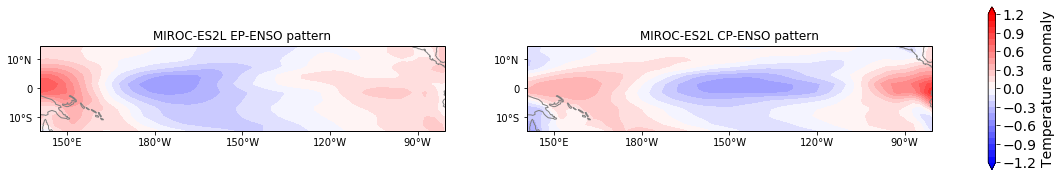

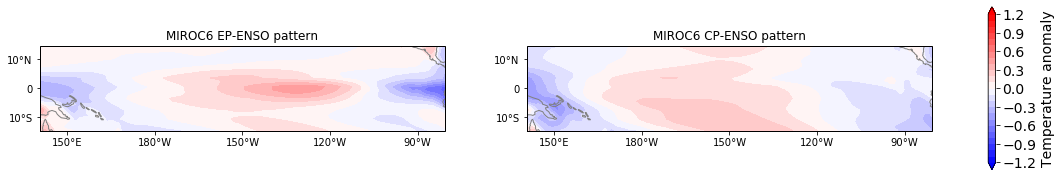

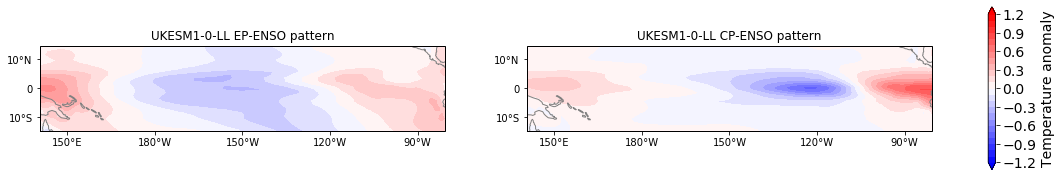

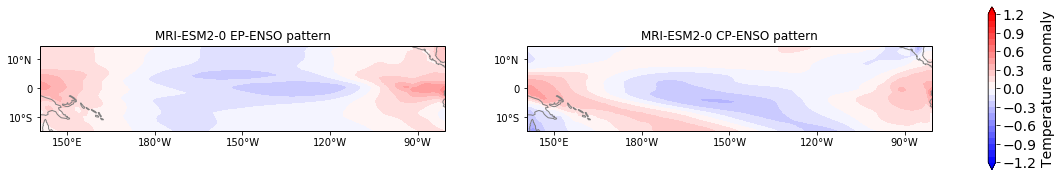

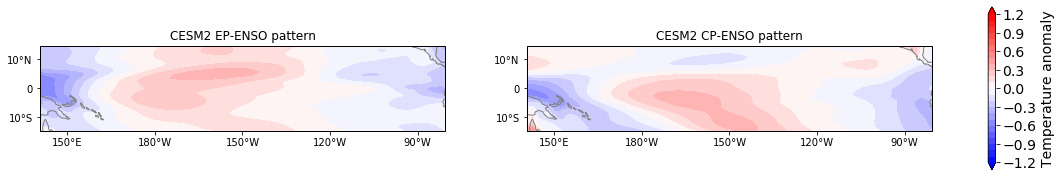

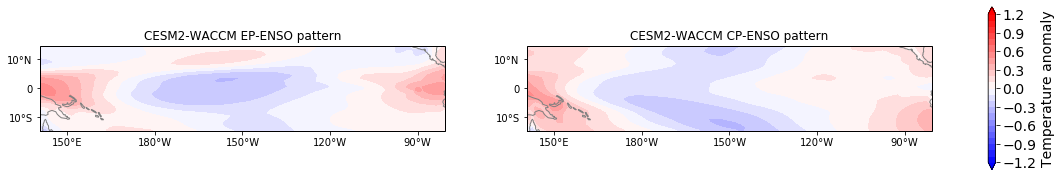

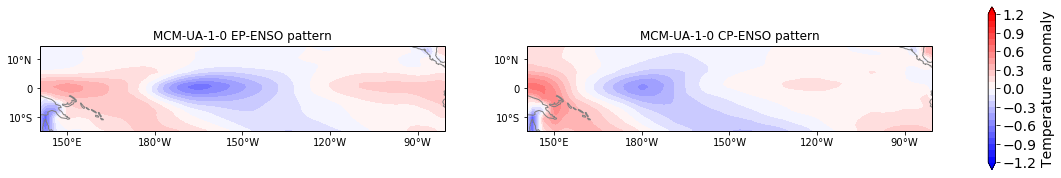

In [9]:

maxval = 1.2; step = 0.1
data_crs = ccrs.PlateCarree(central_longitude=180.0)

for model in models:
    var = model + '_eofs'; var_frac = model + '_variance_fractions'
    eof1 = all_eofs[var].sel(mode=0); var_frac1 = all_variance_fractions[var_frac].sel(mode=0).values
    eof2 = all_eofs[var].sel(mode=1); var_frac2 = all_variance_fractions[var_frac].sel(mode=1).values
    
    var2 = model + '_pcs'
    pc1 = all_pcs[var2].sel(mode=0)
    pc2 = all_pcs[var2].sel(mode=1)
    
    ep_enso = np.sqrt(2)/2*(eof1*pc1.std() - eof2*pc2.std())
    cp_enso = np.sqrt(2)/2*(eof1*pc1.std() + eof2*pc2.std())
    
    fig, ax = plt.subplots(ncols = 2, figsize = [20,3], subplot_kw={'projection': data_crs})
    
    cs0 = ax[0].contourf(all_eofs.lon, all_eofs.lat, (ep_enso).transpose(), np.arange(-maxval,maxval+step,step), cmap = 'bwr',extend='both', transform=ccrs.PlateCarree())
    cs1 = ax[1].contourf(all_eofs.lon, all_eofs.lat, (cp_enso).transpose(), np.arange(-maxval,maxval+step,step), cmap = 'bwr',extend='both', transform=ccrs.PlateCarree())
    for i in [0,1]:
        ax[i].coastlines(color='gray')
    cbar = fig.colorbar(cs1, ax = ax.ravel().tolist(), orientation="vertical")
    cbar.set_label('Temperature anomaly', fontsize = 14)
    cbar.ax.tick_params(labelsize = 14)
    
    ax[0].set_title(model + ' EP-ENSO pattern')
    ax[1].set_title(model + ' CP-ENSO pattern')
    
    plt.setp(ax, xticks = np.arange(150, 280, 30)-180, xticklabels = ['150°E', '180°W', '150°W', '120°W', '90°W'])
    plt.setp(ax, yticks = [-10, 0, 10], yticklabels = ['10°S', '0', '10°N'])
    

## Compute E-index and C-index

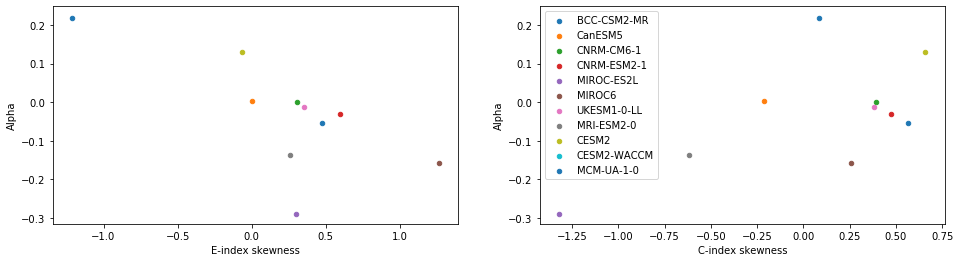

In [36]:
fig, ax = plt.subplots(ncols = 2, figsize = [16,4])

for model in models:
    var = model + '_pcs'
    pc1 = all_pcs[var].sel(mode=0); n_pc1 = pc1/pc1.std()
    pc2 = all_pcs[var].sel(mode=1); n_pc2 = pc2/pc2.std()
    eindex = (n_pc1 - n_pc2)/np.sqrt(2)
    cindex = (n_pc1 + n_pc2)/np.sqrt(2)
    e_skewness = skew(eindex); c_skewness = skew(cindex)

    # quadratic fit
    x = pc1.dropna(dim='time').values; y = pc2.dropna(dim='time').values
    x = x/np.std(x); y = y/np.std(y); x2= np.arange(min(x),max(x),0.01)
    p2 = np.polyfit(x, y, 2)
    alpha = p2[0]  
    ax[0].scatter(e_skewness, alpha, s = 20); ax[0].set_xlabel('E-index skewness')
    ax[1].scatter(c_skewness, alpha, s = 20, label = model); ax[1].set_xlabel('C-index skewness')
    
    for axis in ax:
        axis.set_ylabel('Alpha')
    ax[1].legend()
